# 🤖 ML Model Training

**Train ML models to predict ecosystem dynamics**

Philosophy: Everything is information processing. Simple rules compose. Emergence is reliable.

---

## Contents
1. Setup & Data Loading
2. Feature Engineering
3. Population Prediction (Regression)
4. Stability Classification
5. Death Cause Prediction
6. Feature Importance Analysis
7. Model Comparison
8. Predictions & Validation

## 1. Setup & Data Loading

In [11]:
# Import libraries
import sys
from pathlib import Path

# Add parent directory to path so we can import from src
# sys.path.insert(0, str(Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our ML modules
from src.ml import (
    load_evolution_csv, detect_species_from_columns,
    calculate_birth_rate, calculate_death_rate, calculate_growth_rate,
    normalize_z_score, calculate_rolling_cv,
    prepare_features, create_regression_pipeline,
    create_classification_pipeline, get_feature_importance,
    compare_regression_models
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup complete!")

✅ Setup complete!


In [12]:
# Load evolution data
from src.ml.data_loader import load_evolution_auto


df, meta, config = load_evolution_auto('../../datasets/evolution.jsonl')
species = detect_species_from_columns(df)

print(f"✅ Loaded {len(df)} snapshots")
print(f"✅ Species: {', '.join(species)}")
print(f"\n📊 Dataset shape: {df.shape}")
print(f"📊 Columns: {len(df.columns)}")

✅ Loaded 1000 snapshots
✅ Species: cautious, explorer, independent, predator

📊 Dataset shape: (1000, 42)
📊 Columns: 42


## 2. Feature Engineering

In [13]:
# Engineer features for first species (as example)
test_species = species[0]
print(f"🧪 Engineering features for: {test_species}")

pop_col = f'{test_species}_population'
births_col = f'{test_species}_births'
deaths_col = f'{test_species}_deaths'

# Calculate rates
df['birth_rate'] = calculate_birth_rate(
    df[births_col], df[pop_col], df['deltaSeconds']
)
df['death_rate'] = calculate_death_rate(
    df[deaths_col], df[pop_col], df['deltaSeconds']
)
df['growth_rate'] = calculate_growth_rate(
    df[births_col], df[deaths_col], df[pop_col], df['deltaSeconds']
)

# Calculate stability
df['rolling_cv'] = calculate_rolling_cv(df[pop_col], window=10)

# Create target: next tick population
df['next_population'] = df[pop_col].shift(-1)

print("\n✅ Features engineered:")
print(f"  - birth_rate: {df['birth_rate'].mean():.6f} (mean)")
print(f"  - death_rate: {df['death_rate'].mean():.6f} (mean)")
print(f"  - growth_rate: {df['growth_rate'].mean():.6f} (mean)")
print(f"  - rolling_cv: {df['rolling_cv'].mean():.4f} (mean)")

🧪 Engineering features for: cautious

✅ Features engineered:
  - birth_rate: 0.002981 (mean)
  - death_rate: 0.002844 (mean)
  - growth_rate: 0.000137 (mean)
  - rolling_cv: 0.0057 (mean)


## 3. Population Prediction (Regression)

In [14]:
# Prepare features for regression
feature_cols = ['birth_rate', 'death_rate', 'growth_rate', pop_col, 'rolling_cv']
target_col = 'next_population'

X, y = prepare_features(df, feature_cols, target_col)
print(f"✅ Features prepared: X={X.shape}, y={y.shape}")

# Train regression models
print("\n🤖 Training regression models...")
pipeline = create_regression_pipeline(X, y, test_size=0.2)

print("\n📊 Model Comparison:")
print(pipeline['comparison'].to_string(index=False))

print(f"\n🏆 Best Model: {pipeline['best_model_name']}")
print(f"  Test R²: {pipeline['comparison'].iloc[0]['test_r2']:.4f}")
print(f"  Test RMSE: {pipeline['comparison'].iloc[0]['test_rmse']:.4f}")

✅ Features prepared: X=(998, 5), y=(998,)

🤖 Training regression models...

📊 Model Comparison:
            model  train_r2  test_r2  train_rmse  test_rmse  train_mae  test_mae
Linear Regression  0.911151 0.922160    1.964935   1.958646   1.488897  1.560223
    Random Forest  0.975148 0.912185    1.039209   2.080365   0.821123  1.645885
    Decision Tree  0.926969 0.903062    1.781460   2.185758   1.384564  1.715083

🏆 Best Model: Linear Regression
  Test R²: 0.9222
  Test RMSE: 1.9586


## 4. Feature Importance Analysis

📊 Feature Importance:
            feature  importance
        growth_rate   61.093138
         death_rate   57.207305
         rolling_cv   46.447215
         birth_rate    3.885833
cautious_population    0.972112


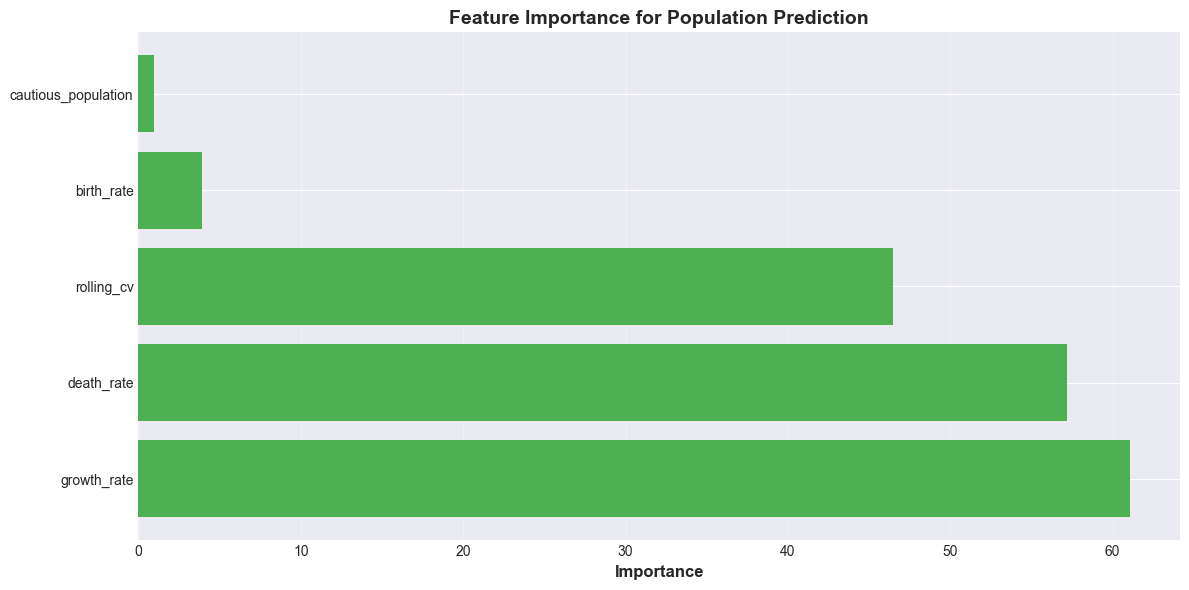

In [15]:
# Extract feature importance
importance = get_feature_importance(pipeline['best_model'], feature_cols)

print("📊 Feature Importance:")
print(importance.to_string(index=False))

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(importance['feature'], importance['importance'], color='#4CAF50')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance for Population Prediction', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. Stability Classification

In [16]:
# Create stability classes
df['stability_class'] = pd.cut(
    df['growth_rate'], 
    bins=[-np.inf, -0.01, 0.01, np.inf],
    labels=['declining', 'stable', 'growing']
)

# Prepare features for classification
X_class, y_class = prepare_features(df, feature_cols, 'stability_class')

print(f"✅ Classification data prepared: X={X_class.shape}, y={y_class.shape}")
print(f"\n📊 Class distribution:")
print(y_class.value_counts())

# Train classification models
print("\n🤖 Training classification models...")
class_pipeline = create_classification_pipeline(X_class, y_class, test_size=0.2)

print("\n📊 Classifier Comparison:")
print(class_pipeline['comparison'].to_string(index=False))

print(f"\n🏆 Best Classifier: {class_pipeline['best_model_name']}")
print(f"  Test Accuracy: {class_pipeline['comparison'].iloc[0]['test_accuracy']:.4f}")
print(f"  Test F1: {class_pipeline['comparison'].iloc[0]['test_f1']:.4f}")

✅ Classification data prepared: X=(999, 5), y=(999,)

📊 Class distribution:
stability_class
stable       988
growing       10
declining      1
Name: count, dtype: int64

🤖 Training classification models...

📊 Classifier Comparison:
              model  train_accuracy  test_accuracy  train_f1  test_f1  train_precision  test_precision  train_recall  test_recall
Logistic Regression        0.986233            1.0  0.979397      1.0         0.972655             1.0      0.986233          1.0
      Decision Tree        1.000000            1.0  1.000000      1.0         1.000000             1.0      1.000000          1.0
      Random Forest        1.000000            1.0  1.000000      1.0         1.000000             1.0      1.000000          1.0

🏆 Best Classifier: Logistic Regression
  Test Accuracy: 1.0000
  Test F1: 1.0000


## 6. Predictions & Validation

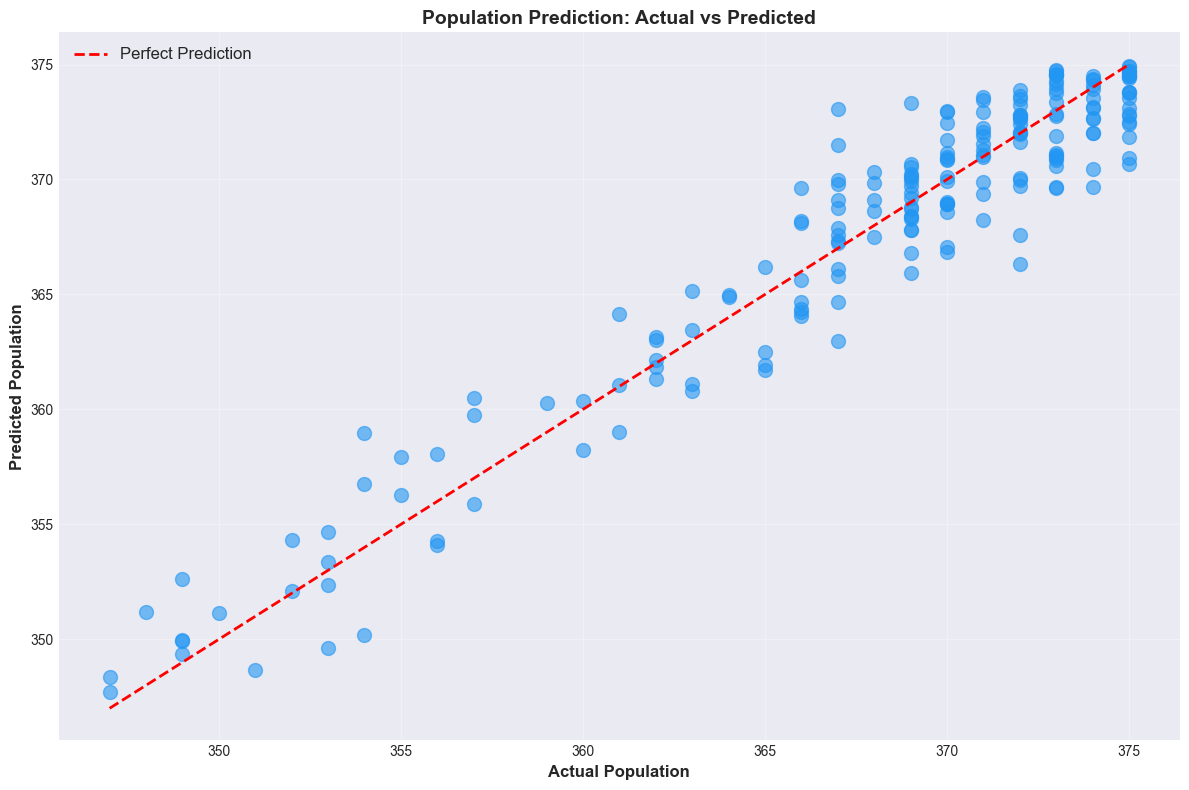


📊 Prediction Quality:
  Mean Absolute Error: 1.56 boids
  Max Error: 6.07 boids
  R² Score: 0.9222


In [17]:
# Make predictions on test set
from src.ml.models import predict

y_pred = predict(pipeline['best_model'], pipeline['X_test'])
y_true = pipeline['y_test']

# Plot predictions vs actual
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_true, y_pred, alpha=0.6, s=100, color='#2196F3')
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
       'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual Population', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Population', fontsize=12, fontweight='bold')
ax.set_title('Population Prediction: Actual vs Predicted', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate residuals
residuals = y_true - y_pred
print(f"\n📊 Prediction Quality:")
print(f"  Mean Absolute Error: {np.abs(residuals).mean():.2f} boids")
print(f"  Max Error: {np.abs(residuals).max():.2f} boids")
print(f"  R² Score: {pipeline['comparison'].iloc[0]['test_r2']:.4f}")

## 7. Training Summary

In [18]:
print("\n" + "="*70)
print("🤖 ML TRAINING SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total Samples: {len(df):,}")
print(f"  Training Samples: {len(pipeline['X_train']):,}")
print(f"  Test Samples: {len(pipeline['X_test']):,}")

print(f"\n🎯 Regression (Population Prediction):")
print(f"  Best Model: {pipeline['best_model_name']}")
print(f"  Test R²: {pipeline['comparison'].iloc[0]['test_r2']:.4f}")
print(f"  Test RMSE: {pipeline['comparison'].iloc[0]['test_rmse']:.4f}")
print(f"  Test MAE: {pipeline['comparison'].iloc[0]['test_mae']:.4f}")

print(f"\n🎯 Classification (Stability State):")
print(f"  Best Model: {class_pipeline['best_model_name']}")
print(f"  Test Accuracy: {class_pipeline['comparison'].iloc[0]['test_accuracy']:.4f}")
print(f"  Test F1: {class_pipeline['comparison'].iloc[0]['test_f1']:.4f}")

print(f"\n💡 Top 3 Features:")
for i, row in importance.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.2f}")

print("\n" + "="*70)
print("✅ Training Complete!")
print("="*70)


🤖 ML TRAINING SUMMARY

📊 Dataset:
  Total Samples: 1,000
  Training Samples: 798
  Test Samples: 200

🎯 Regression (Population Prediction):
  Best Model: Linear Regression
  Test R²: 0.9222
  Test RMSE: 1.9586
  Test MAE: 1.5602

🎯 Classification (Stability State):
  Best Model: Logistic Regression
  Test Accuracy: 1.0000
  Test F1: 1.0000

💡 Top 3 Features:
  3. growth_rate: 61.09
  2. death_rate: 57.21
  5. rolling_cv: 46.45

✅ Training Complete!
